# Coordinate Descent and Soft-Thresholding for Lasso Regression

## Introduction  

This notebook explores these topics on Lasso Regression
- Solve lasso regression with orthogonal design matrix with soft-thresholding
- Solve multivariate lasso regression using coordinate descent when the design matrix is properly scaled
- Re-scale the lasso parameters estimate back onto the orignal scale of the data  
- Implement pathwise coordinate descent to estimate lasso parameters efficiently

This notebook requires some prior knowlege about regression analysis and lasso regression

## 1. Soft-thresholding a lasso problem

In a classical regression problem, the assumption placed on data is:  
$$y = X\beta + \epsilon$$  
Where $y$ is a vector of size $(n, 1)$, $X$ a matrix of size $(n, p)$, $\beta$ a vector of size $(p, 1)$, and $\epsilon$ a vector of size $(n, 1)$. Also, $\epsilon \sim N(0, \sigma^2)$  
Define the loss function of lasso regression:  

$$\frac{1}{2n}|| y - X\beta ||^2 = \frac{1}{2n}|| y - X\hat{\beta}^{OLS} + X\hat{\beta}^{OLS} - X\beta||^2 + \lambda|| \beta ||^1$$  
  
$$\hspace{3.2cm}=\frac{1}{2n}|| y - X\hat{\beta}^{OLS}||^2 + || X\hat{\beta}^{OLS} - X\beta||^2+ \lambda|| \beta ||^1$$  
Where the cross product term:
$$2(y - X\hat{\beta}^{OLS})^T( X\hat{\beta}^{OLS} - X\beta)=2r^{T}(X\hat{\beta}^{OLS} - X\beta)=0$$  


because the second term is on the column space of $X$, which is orthogonal to $r$, the residual of OLS.

Now since $||y - X\hat{\beta}^{OLS}||^2$ is not a function of $\beta$, the loss function is minimized by minimizing $||X\hat{\beta}^{OLS} - X\beta||^2+ \lambda||\beta||^1$

We have:  
$$\hat{\beta}^{lasso}=\frac{1}{2n}||X\hat{\beta}^{OLS} - X\beta||^2+ \lambda||\beta||^1$$  

$$\hspace{5.8cm}=argmin\hspace{0.1cm}\frac{1}{2n}(X\hat{\beta}^{OLS} - X\beta)^{T}X^{T}X(X\hat{\beta}^{OLS} - X\beta) + \lambda||\beta||^1$$  

$$\hspace{5cm}Assume\hspace{0.3cm}we\hspace{0.3cm}have\hspace{0.3cm}X^{T}X=nI$$  

$$\hspace{3.2cm}=argmin\hspace{0.1cm}\frac{1}{2}(\hat{\beta}^{OLS} - \beta)^{T}(\hat{\beta}^{OLS} - \beta) + \lambda||\beta||^1$$  
$$\hspace{2.3cm}=argmin\hspace{0.1cm}\frac{1}{2}\Sigma_{j=1}^{p}(\beta_{j}^{OLS} - \beta_{j})^2+ \lambda||\beta_{j}||^1$$  

**This further implies we can shove the lasso estimateors individually from the OLS estimator.**

$$For\hspace{0.1cm}each\hspace{0.1cm}\beta_{j}:$$
$$\beta_{j}=argmin\hspace{0.1cm}\frac{1}{2}(\beta -\beta_{j}^{OLS})^{2}+\lambda|\beta_{i}|$$  
$$Take\hspace{0.1cm}derivative\hspace{0.1cm}yields:$$
$$\hat{\beta_{j}^{lasso}}=(sign\hspace{0.1cm} \beta_{j}^{OLS})(|\beta_{j}^{OLS}|-\lambda)^+$$


### Implementation

In [24]:
# Algorithm Implementation
import numpy as np

# soft thresholding function
def soft_th(b, lambda_):
    if (abs(b) - lambda_) > 0:
        result = np.sign(b) * (abs(b) - lambda_)
        return result
    else:
        return 0

### Simulation Study  

In this simulation, the original $X \sim N(0, 1)$, and is later scaled to be orthogonal such that $X^{T}X = nI$, $y$ is generated to be $y = X_{scaled} + \epsilon$ where $\epsilon \sim N(0, 1)$

In [25]:
# generate data
np.random.seed(1)
n = 100
X = np.random.normal(0, 1, (n, 1))
X = X / np.sqrt(sum(X*X) / n)
Y = X + np.random.normal(0, 1, (n, 1))

beta_OLS = np.linalg.inv(X.transpose() @ X) @ X.transpose() @ Y

In [29]:
import pandas as pd

beta_lasso = [] 
for lambda_ in np.arange(0, 1, 0.1):
    beta_lasso.append(soft_th(beta_OLS, lambda_)[0][0])
    
df = pd.DataFrame({'lambda': np.arange(0.00, 1, 0.1), 'beta1': beta_lasso})

df

,lambda,beta1
0,0.0,1.094704
1,0.1,0.994704
2,0.2,0.894704
3,0.3,0.794704
4,0.4,0.694704
5,0.5,0.594704
6,0.6,0.494704
7,0.7,0.394704
8,0.8,0.294704
9,0.9,0.194704


## Intercept, centering and Scaling Issue - One Variable Case

A common practice when dealing with the intercept and scaling is to perform the following:

1. Center and scale both $X$ (column-wise) and $y$, denote the processed data as $Y−sd_y$ and $X_{j}−sd_j$.  
2. Fit a no-intercept linear regression (or Lasso) on the processed data, and obtain the parameter estimates $\gamma_{j}$. In our case, there is only one $j$, i.e. $p=1$.
3. Recover the original parameters $\beta_0$ and $\beta_j$.


Parameters on the original scale can be recovered by:  
$$\frac{Y−\bar{Y}}{sd_y} = \Sigma_{j=1}^{p}\frac{X_j−\bar{X_j}}{sd_j}\gamma_j$$
$$Y=\bar{Y}-\Sigma_{j=1}^{p}\bar{X_j}\frac{sd_{y}⋅\gamma_{j}}{sd_j}+\Sigma_{j=1}^{p}X_j\frac{sd_{y}⋅\gamma_{j}}{sd_j}$$

Where:
$$\bar{Y}-\Sigma_{j=1}^{p}\bar{X_j}\frac{sd_{y}⋅\gamma_{j}}{sd_j}=\beta_0$$
$$\frac{sd_{y}⋅\gamma_{j}}{sd_j}=\beta_j$$

### Implementation

In [ ]:
## Inplementation
def lasso_rescale(X, Y, lambda_):
    X_mean, X_std, Y_mean, Y_std = X.mean(axis=0), X.std(axis=0), Y.mean(axis=0), Y.std(axis=0)
    X_scale = X.copy()
    Y_scale = Y.copy()
    for i, column in enumerate(X_scale.T):
        X_scale[:,i] = (column - X_mean[i]) / X_std[i]
    Y_scale = (Y_scale - Y_mean[0]) / Y_std[0]
    beta_OLS = np.linalg.inv(X_scale.transpose() @ X_scale) @ X_scale.transpose() @ Y_scale
    
    beta_lasso = []
    beta_scale = []
    for i, beta in enumerate(beta_OLS):
        est = soft_th(beta, lambda_)
        beta_lasso.append(est)
        est_scale = (est * Y_std[0]) / X_std[i]
        beta_scale.append(est_scale[0])
    
    beta_0_scale = Y_mean[0] - sum(np.array(beta_scale) * X_mean)
    beta_scale.insert(0, beta_0_scale)
    
    return(beta_scale)

### Simulation Study  

In this simulation, the original $X \sim N(1, 2)$, and $y$ is generated to be $y = 1 + X_{scaled} + \epsilon$ where $\epsilon \sim N(0, 1)$

In [33]:
np.random.seed(1)
n = 100
X = np.random.normal(1, 2, (n, 1))
Y = 1 + X + np.random.normal(0, 1, (n, 1))

beta_lasso = [] 
for lambda_ in np.arange(0, 0.9, 0.1):
    beta_lasso.append(lasso_rescale(X, Y, lambda_))
    

beta_array = np.array(beta_lasso)
df = pd.DataFrame({'lambda': np.arange(0, 0.9, 0.1), 'beta0': beta_array[:,0], 'beta1': beta_array[:,1]})

print(df)

   lambda     beta0     beta1
0     0.0  1.099300  1.047714
1     0.1  1.230653  0.930556
2     0.2  1.362006  0.813399
3     0.3  1.493358  0.696241
4     0.4  1.624711  0.579084
5     0.5  1.756064  0.461927
6     0.6  1.887417  0.344769
7     0.7  2.018770  0.227612
8     0.8  2.150123  0.110455


## 2. Extending to multi-variable Case

### Generalize to a One Variable Case

The idea is simple:  

Let $\beta_{(−j)}$ denote the vector by removing the $j$th entry, and $X_{(−j)}$
be the corresponding design matrix by removing the $j$th column
from $X$.  

The coordinate descent problem at the kth iteration is to find
$$argmin\frac{1}{2n}||y - X_{j}\beta_{j} - X_{(−j)}\beta_{(−j)}^{(k)}||^2_{2}+ \lambda\Sigma_{i=1}^{p}||\beta_{i}||^1$$
$$=argmin\frac{1}{2n}||y - X_{j}\beta_{j} - X_{(−j)}\beta_{(−j)}^{(k)}||^2_{2}+ \lambda||\beta_{j}||^1$$

**This is a one-dimensional Lasso problem**  

Now the OLS solution to the squared-loss part is simply $\beta_{j}^{OLS}=\frac{X^{T}_jr}{X^{T}_jX_{j}}$  
and adding the penalty is simply performing a soft-thresholding
to the OLS solution.

### Further improve the efficiency of the coordinate descent
Calculating the residual $r = y  - X_{(−j)}\beta_{(−j)}^{(k)}$
can be very costly
since it involves multiplying using a $n × (p − 1)$ matrix  

**Instead, since we only update one $\beta_{j}$ at a time, the residual $r$ at the next iteration can be obtained with**  
$$r^{new}=r-X_{(j)}\beta_{(j)}^{(k+1)}-X_{(j+1)}\beta_{(j+1)}^{(k)}$$

### Implementation

In [51]:
# coordinate descent function
def coord_desc(X, y, lam, b, maxiter=100, tol=1e-7):
    beta = b.copy()
    for i in range(maxiter):
        beta_org = beta.copy()
        for j in range(X.shape[1]):
            r = y - (np.delete(X, j, axis=1) @ np.delete(beta, j)).reshape(-1,1)
            beta_j_OLS = (X[:,j].reshape(-1,1).transpose() @ r) / X.shape[0]
            beta_j_lasso = soft_th(beta_j_OLS, lam)
            beta[j] = beta_j_lasso
        if np.linalg.norm(beta_org - beta) <= tol:
            break
    return beta

### A Simulation Study

In [52]:
np.random.seed(10)
n = 100
p = 200
  
# generate data
V = np.full((p, p), 0.3)
np.fill_diagonal(V, 1)
X_org = np.random.multivariate_normal(mean=np.zeros(p), cov=V, size=n)
true_b = np.concatenate((np.random.uniform(-1, 1, 10), np.zeros(p-10))).reshape(-1, 1)
y_org = X_org @ true_b + np.random.normal(0, 1, (n, 1))

# pre-scale and center X and y
X_mean, X_std, y_mean, y_std = X_org.mean(axis=0), X_org.std(axis=0), y_org.mean(axis=0), y_org.std(axis=0)
X = X_org.copy()
y = y_org.copy()

for i, column in enumerate(X.T):
        X[:,i] = (column - X_mean[i]) / X_std[i]
y = (y - y_mean[0]) / y_std[0]

In [54]:
from sklearn import linear_model

lam = 0.3

# coord descent algo
beta_lasso = coord_desc(X, y, lam, b=np.zeros(p).reshape(-1, 1), maxiter=100, tol=1e-7)


# lasso from scikit-learn
model = linear_model.Lasso(alpha=lam, tol=1e-07, fit_intercept=False)
model.fit(X, y)

df = pd.DataFrame({'Coord_Desc': beta_lasso[:10].flatten(), 'Scikit Lasso': model.coef_[:10]})
df

,Coord_Desc,Scikit Lasso
0,-0.214533,-0.214533
1,0.000000,0.000000
2,-0.080530,-0.080530
3,-0.107968,-0.107968
4,0.000000,-0.000000
5,0.000000,-0.000000
6,0.000000,-0.000000
7,0.000000,-0.000000
8,0.000000,0.000000
9,-0.086106,-0.086106


## 2. Extending to Multiple Lambda Values - Pathwise Coordinate Descent

The idea is simple: we will solve the solution on a grid of $\lambda$ values, starting from the largest one. After obtaining the optimal $\beta$ for a given $\lambda$, we simply use this solution as the initial value (instead of all zero) for the next (smaller) $\lambda$. This is referred to as a warm start in optimization problems.

In [55]:
def path_coord_desc(X, y, lambda_array, maxiter=100, tol=1e-7):
    lambda_sorted = np.sort(lambda_array)[::-1]
    b = np.zeros(X.shape[1]).reshape(-1, 1)
    betas = pd.DataFrame(index = range(X.shape[1]), columns=lambda_sorted)
    for i, lam in enumerate(lambda_sorted):
        if i == 0:
            b = b
        else:
            b = betas.iloc[:,i-1].to_numpy()
        beta = coord_desc(X, y, lam, b=b, maxiter=maxiter, tol=tol)
        betas[lam] = beta
    return(betas)

In [57]:
lambda_array = np.arange(0.1, 0.9, 0.1)

# coord_desc
betas = path_coord_desc(X, y, lambda_array, maxiter=100, tol=1e-7)

# scikit-learn implementation
alphas_lasso, coefs_lasso, _ = linear_model.lasso_path(X, y, alphas=lambda_array, fit_intercept=False)

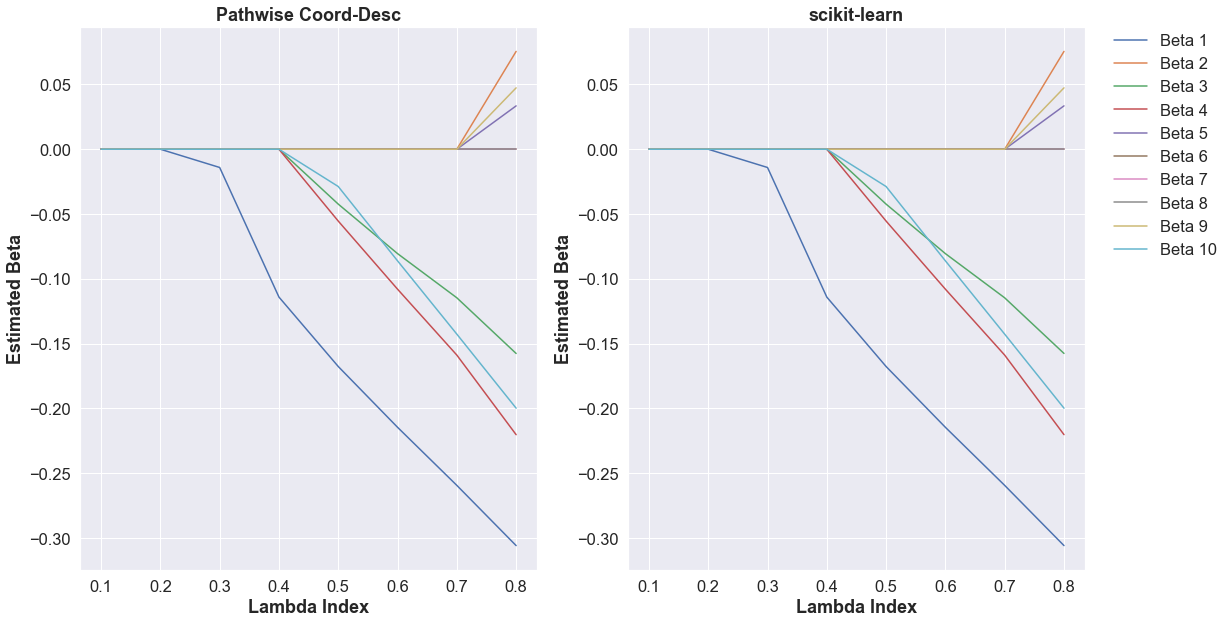

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(1, 2, 1)
for i in range(10):
    sns.lineplot(x=lambda_array, y=betas.iloc[i,:])
x_lab = plt.xlabel('Lambda Index', weight='bold')
y_lab = plt.ylabel('Estimated Beta', weight='bold')
plt.title('Pathwise Coord-Desc', weight='bold')

ax = fig.add_subplot(1, 2, 2)
for i in range(10):
    sns.lineplot(x=lambda_array, y=coefs_lasso[0,i,:], label='Beta {}'.format(str(i+1)))
x_lab = plt.xlabel('Lambda Index', weight='bold')
y_lab = plt.ylabel('Estimated Beta', weight='bold')
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
t= plt.title('scikit-learn', weight='bold')